In [56]:
import os
import librosa
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import librosa.effects

class BabyCryDataset(Dataset):
    def __init__(self, data_dir, transform=None, fixed_length=300, device='cuda', n_fft=512): # Added device argument
        self.data_dir = data_dir
        self.classes = os.listdir(data_dir)
        self.file_paths = []
        self.labels = []
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(data_dir, class_name)
            for file_name in os.listdir(class_dir):
                self.file_paths.append(os.path.join(class_dir, file_name))
                self.labels.append(label)
        self.transform = transform
        self.fixed_length = fixed_length #Added fixed length
        self.device = device # Added device
        self.n_fft = n_fft # Added n_fft

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        audio, sr = librosa.load(self.file_paths[idx], sr=16000)
        # Trim non-silence parts
        audio_trimmed, index = librosa.effects.trim(audio, top_db=20) # Adjust top_db as needed
        mel_spectrogram = librosa.feature.melspectrogram(y=audio_trimmed, sr=sr, n_mels=128, n_fft=self.n_fft)
        mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        mel_spectrogram = torch.tensor(mel_spectrogram).float()
        mel_spectrogram = mel_spectrogram.to(self.device) # Move mel_spectrogram to device here

        # Padding/Truncating
        if mel_spectrogram.shape[1] < self.fixed_length:
            pad_size = self.fixed_length - mel_spectrogram.shape[1]
            mel_spectrogram = torch.nn.functional.pad(mel_spectrogram, (0, pad_size))
        elif mel_spectrogram.shape[1] > self.fixed_length:
            mel_spectrogram = mel_spectrogram[:, :self.fixed_length]

        label = torch.tensor(self.labels[idx]).long()
        label = label.to(self.device) # Move label to device here
        if self.transform:
            mel_spectrogram = self.transform(mel_spectrogram)
        return mel_spectrogram, label

class CryClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CryClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 64 * 150, num_classes) # Corrected input size

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        print(f"Shape before fc1: {x.shape}") # Debugging print
        x = self.fc1(x)
        return x


# 3. Training Process
def train(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        print(f'Epoch {epoch+1}, Val Loss: {val_loss/len(val_loader)}')
        
def validate(model, val_loader, criterion, device):
    """
    Validates the model on the validation set.

    Args:
        model (nn.Module): The trained model.
        val_loader (DataLoader): DataLoader for the validation set.
        criterion (nn.Module): Loss function.
        device (torch.device): Device to run the validation on (CPU or GPU).

    Returns:
        tuple: Validation loss, accuracy, precision, recall, and F1-score.
    """
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device) # send data to device
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0) #Handle zero division
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0) #Handle zero division
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0) #Handle zero division

    return avg_val_loss, accuracy, precision, recall, f1

# Example usage (assuming train_loader, val_loader, model, criterion, and optimizer are already defined):

data_dir = 'donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Use GPU if available

dataset = BabyCryDataset(data_dir, device=device) # Pass device to dataset
train_data, val_data = train_test_split(dataset, test_size=0.2)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

model = CryClassifier(num_classes=len(dataset.classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


model.to(device) # Move the entire model to the GPU

train(model, train_loader, val_loader, criterion, optimizer, epochs=5000, device=device)

Shape before fc1: torch.Size([32, 307200])
Shape before fc1: torch.Size([32, 307200])
Shape before fc1: torch.Size([32, 307200])
Shape before fc1: torch.Size([32, 307200])
Shape before fc1: torch.Size([32, 307200])
Shape before fc1: torch.Size([32, 307200])
Shape before fc1: torch.Size([32, 307200])
Shape before fc1: torch.Size([32, 307200])
Shape before fc1: torch.Size([32, 307200])
Shape before fc1: torch.Size([32, 307200])
Shape before fc1: torch.Size([32, 307200])
Shape before fc1: torch.Size([32, 307200])
Shape before fc1: torch.Size([32, 307200])
Shape before fc1: torch.Size([32, 307200])
Shape before fc1: torch.Size([32, 307200])
Shape before fc1: torch.Size([32, 307200])
Shape before fc1: torch.Size([32, 307200])
Shape before fc1: torch.Size([32, 307200])
Shape before fc1: torch.Size([32, 307200])
Shape before fc1: torch.Size([32, 307200])
Shape before fc1: torch.Size([32, 307200])
Shape before fc1: torch.Size([32, 307200])
Shape before fc1: torch.Size([32, 307200])
Shape befor

Visualizing Mel spectrogram for: donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/hungry\fa8620d3-e7db-4101-aff0-28dbf0d96a5f-1429973911232-1.7-m-04-hu.wav


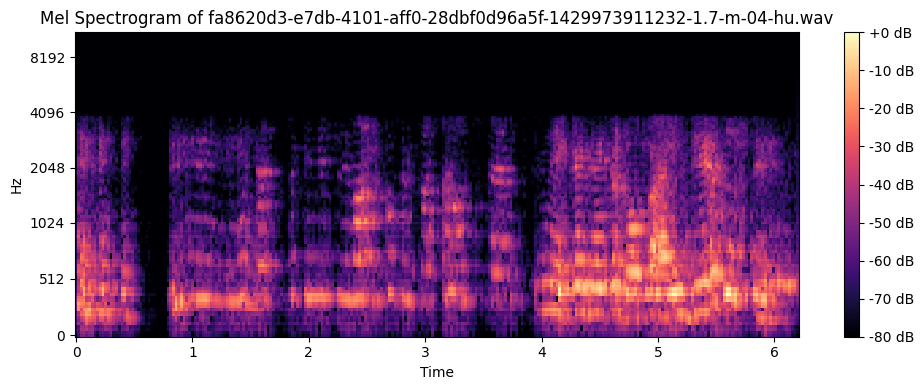

In [53]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import random

data_dir = 'donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/'

classes = os.listdir(data_dir)
file_paths = []
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    for file_name in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, file_name))

# Choose a random file
random_file_path = random.choice(file_paths)
print(f"Visualizing Mel spectrogram for: {random_file_path}")

# Load audio file
y, sr = librosa.load(random_file_path)

# Trim non-silence parts (optional, but good practice)
y_trimmed, index = librosa.effects.trim(y, top_db=20)
y = y_trimmed # Use trimmed audio for spectrogram

# Calculate Mel spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=512) # Using n_fft=512
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

# Plot Mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel Spectrogram of {os.path.basename(random_file_path)}')
plt.tight_layout()
plt.show()

In [57]:
avg_val_loss, accuracy, precision, recall, f1 = validate(
    model, val_loader, criterion, device)
print(
    f'Validation Loss: {avg_val_loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}')

Shape before fc1: torch.Size([32, 307200])
Shape before fc1: torch.Size([32, 307200])
Shape before fc1: torch.Size([32, 307200])
Shape before fc1: torch.Size([32, 307200])
Shape before fc1: torch.Size([32, 307200])
Shape before fc1: torch.Size([29, 307200])
Validation Loss: 4.5009580453236895, Accuracy: 0.6137566137566137, Precision: 0.6244401304353343, Recall: 0.6137566137566137, F1: 0.6146695481747652


In [58]:
import torch

# Assuming your model is already trained and called 'model'
# For example, model = CryClassifier(num_classes=len(dataset.classes))

# Define the path where you want to save the model
MODEL_PATH = "baby_cry_model_torch.pth"  # You can choose any filename with the .pth extension

# Save the model's state_dict
torch.save(model.state_dict(), MODEL_PATH)

print(f"Model saved to: {MODEL_PATH}")

Model saved to: baby_cry_model_torch.pth


In [4]:
import torch
import torch.onnx

# Instantiate the model with the correct number of classes
num_classes = 5 # Replace with the actual number of classes in your dataset
model = CryClassifier(num_classes=num_classes)

# Load the saved state dictionary
MODEL_PATH = "baby_cry_model_torch.pth" # Path where you saved your PyTorch model
model.load_state_dict(torch.load(MODEL_PATH))
model.eval() # Set model to evaluation mode

# Define a sample input - adjust the shape to match your model's input
dummy_input = torch.randn(1, 128, 300) # Batch size 1, Mel spectrogram shape (n_mels x fixed_length)

# Output path for ONNX model
ONNX_MODEL_PATH = "baby_cry_model_torch.onnx"

# Export to ONNX
torch.onnx.export(model,
                  dummy_input,
                  ONNX_MODEL_PATH,
                  export_params=True,    # Export trained weights
                  opset_version=11,      # ONNX opset version (adjust if needed)
                  do_constant_folding=True,  # Optimization
                  input_names = ['input'],   # Input name
                  output_names = ['output'], # Output name
                  dynamic_axes={'input' : {0 : 'batch_size'},    # Dynamic batch size
                                'output' : {0 : 'batch_size'}})
print(f"ONNX model saved to: {ONNX_MODEL_PATH}")

Shape before fc1: torch.Size([1, 307200])
ONNX model saved to: baby_cry_model_torch.onnx


In [1]:
import onnx
from onnx_tf.backend import prepare

ONNX_MODEL_PATH = "baby_cry_model.onnx" # Path to your ONNX model
TF_SAVED_MODEL_PATH = "tf_saved_model"   # Path to save TensorFlow SavedModel

# Load the ONNX model
onnx_model = onnx.load(ONNX_MODEL_PATH)

# Prepare the model for TensorFlow backend
tf_rep = prepare(onnx_model)

# Export to TensorFlow SavedModel
tf_rep.export_graph(TF_SAVED_MODEL_PATH)
print(f"TensorFlow SavedModel saved to: {TF_SAVED_MODEL_PATH}")



Failed to import TF-Keras. Please note that TF-Keras is not installed by default when you install TensorFlow Probability. This is so that JAX-only users do not have to install TensorFlow or TF-Keras. To use TensorFlow Probability with TensorFlow, please install the tf-keras or tf-keras-nightly package.
This can be be done through installing the tensorflow-probability[tf] extra.




ModuleNotFoundError: No module named 'tf_keras'